# Applying GARCH models

## Package imports

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import scipy.stats as stats
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

## Get financial data

In [4]:
ticker = 'TSLA'
start = dt.datetime(2016, 1, 1)
#end = dt.datetime(2020, 1, 1)
end = dt.datetime.today()
data = pdr.get_data_yahoo(ticker, start, end)
data.tail()

#ret = data['Adj Close'].pct_change().dropna()
ret = np.log(1 + data['Adj Close'].pct_change()).dropna()
print(ret.tail())

ann_ret = (1 + np.mean(ret))**252 - 1
print("Annualized returns: ", round(ann_ret, 4)*100, "%")
ann_vol = ret.std() * np.sqrt(252)
print("Annualized volatility: ", round(ann_vol, 4)*100, "%")

Date
2021-01-21   -0.006441
2021-01-22    0.001951
2021-01-25    0.039555
2021-01-26    0.002597
2021-01-27   -0.021669
Name: Adj Close, dtype: float64
Annualized returns:  79.46 %
Annualized volatility:  57.75 %


## Cumulative returns percentage

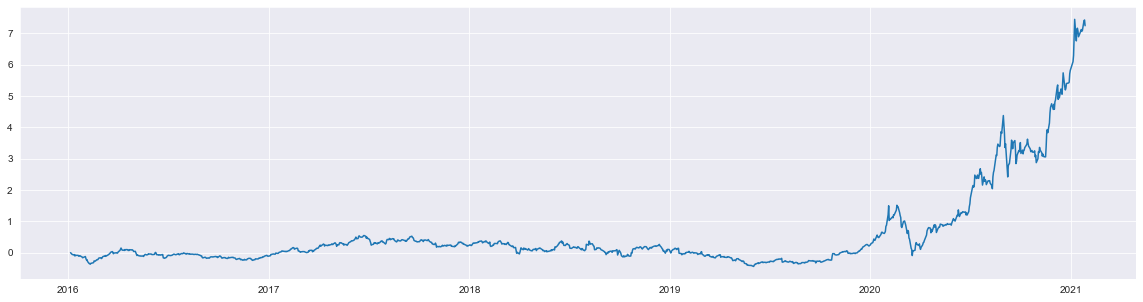

In [64]:
plt.plot(((1+ret).cumprod() - 1))
plt.rcParams["figure.figsize"] = (20, 10)

## Distribution moments and normality tests

Mean:  0.002323284068681507
Volatility: 0.03636245524435476
Skewness:  -0.22894993931331195
Kurtosis:  6.070068429684499
ShapiroResult(statistic=0.9153500199317932, pvalue=4.3102447740854423e-26)
AndersonResult(statistic=22.892819612962285, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


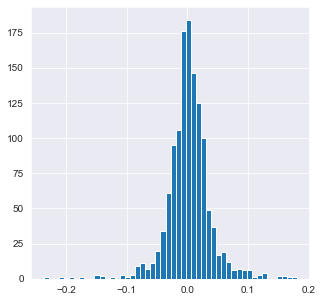

In [6]:
print("Mean: ", np.mean(ret))
print("Volatility:", np.std(ret))
print("Skewness: ", stats.skew(ret))
print("Kurtosis: ", stats.kurtosis(ret)) #excess

plt.rcParams["figure.figsize"] = (5, 5)
ret.hist(bins = 50)

print(stats.shapiro(ret))
print(stats.anderson(ret, 'norm'))


Distribution shows small negative skew and large excess kurtosis. This indicates that the returns are not normally distributed. We implement a Shapiro-Wilk test to confirm this. H0 assumes normality of returns.

Below is a function for finding the best fitting distribution. Kolmogorov-Smirnov test H0 assumes that sample is drawn from the respective distribution. Refer to https://docs.scipy.org/doc/scipy/reference/stats.html for list of all distribution choices.

In [7]:
def get_best_distribution(data):
    dist_names = ["norm", "skewnorm", "t", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    
    # store the name of the best fit and its p value
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

get_best_distribution(ret)

p value for norm = 8.66573853638573e-09
p value for skewnorm = 1.381932723244521e-08
p value for t = 0.8122667785780416
p value for exponweib = 3.1089484486675833e-09
p value for weibull_max = 5.508426456575878e-21
p value for weibull_min = 3.845892840722921e-17


E:\CODE\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 1.5301784878982236e-253
p value for genextreme = 5.7200126762933505e-21
Best fitting distribution: t
Best p value: 0.8122667785780416
Parameters for the best fit: (2.733051798468134, 0.001968028220186887, 0.021560048602277938)


('t',
 0.8122667785780416,
 (2.733051798468134, 0.001968028220186887, 0.021560048602277938))

## Conditional volatility exploration

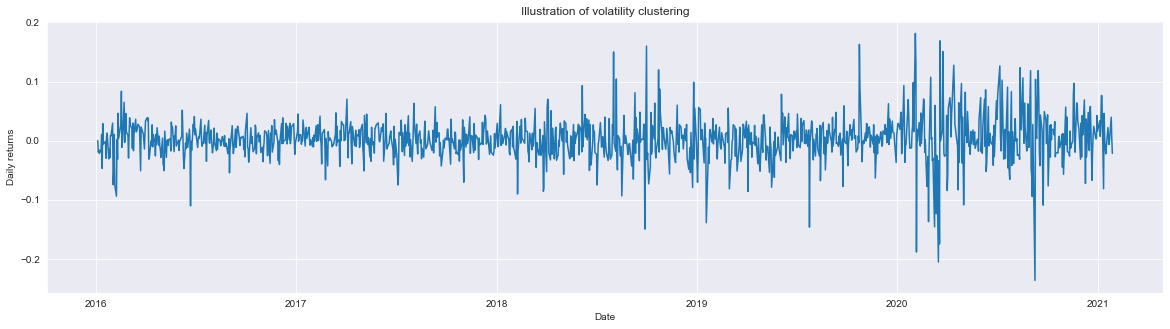

In [50]:
plt.plot(ret)
plt.title('Illustration of volatility clustering')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.rcParams["figure.figsize"] = (20, 5)

As we can see by examining the plot of daily returns, volatility seems to change after 2018 and after 2020. Statistical tests to confirm this are Bartlett and Levene for distributions that are significantly different from normal. Both null hypothesis assume that samples come from populations with the same variance.

In [9]:
# ticker = 'TSLA'
start1 = dt.datetime(2016, 1, 1)
end1 = dt.datetime(2017, 12, 31)
start2 = dt.datetime(2018, 1, 1)
end2 = dt.datetime(2019, 12, 31)
start3 = dt.datetime(2020, 1, 1)
end3 = dt.datetime.today()

# define a function
def ret_f(ticker,begdate,enddate):
    p =pdr.get_data_yahoo(ticker, start=begdate, end=enddate)
    ret = 100*np.log(p['Close'].pct_change()+1).dropna()
    return ret

r1 = ret_f(ticker, start1, end1)
r2 = ret_f(ticker, start2, end2)
r3 = ret_f(ticker, start3, end3)

print(round(r1.std(), 4), round(r2.std(), 4), round(r3.std(), 4))
print(stats.bartlett(r1, r2, r3))

print(stats.levene(r1, r2, r3, center = 'mean'))
#print(stats.levene(r1, r2, r3, center = 'trimmed', proportiontocut = 0.05))

2.3272 3.3888 5.5459
BartlettResult(statistic=284.95248556427885, pvalue=1.3284767478315876e-62)
LeveneResult(statistic=65.32052352254934, pvalue=9.949776335658965e-28)


## GARCH parameter fitting guide

Our stock data seems to exhibit heteroskedasticity, requiring us to use more advanced models like GARCH to fit volatility. To get an idea for (p, q) values we first plot the partial-autocorrelation of squared returns.

Short guidelines for fitting the arch_model() parameters:
    - mean = 'Constant' / 'Zero' / 'AR' / etc. Default is 'Constant'. Use 'Zero' when modeling components separately with AR, MA or ARMA. Use 'AR' or more advanced options when mean is not constant, specifying number of lags.
    - vol = default is 'GARCH', but other options are supported. 'EGARCH' uses log of variance instead of variance. Using this variation frees alpha and beta from their negative constraints.
    - p = lag order for error term
    - o = lag order for assymetric innovation - GARCH models assumpe positive and negative news have a symmetric impact on volatility. This is not true for real world data, as negative news has more impact. To account for this use o > =1, resulting in a GJR-GARCH model.
    - q = lag order for volatility
    - power = power to use with model (default = 2.0, 1.0 for TARCH)
    - dist = 'normal' / 't' / 'skewt' / 'ged', specify the distribution which best fits the standardized residuals. Default is 'normal'.
    - rescale = parameter for optional scaling of the dependent variable to avoid convergence errors

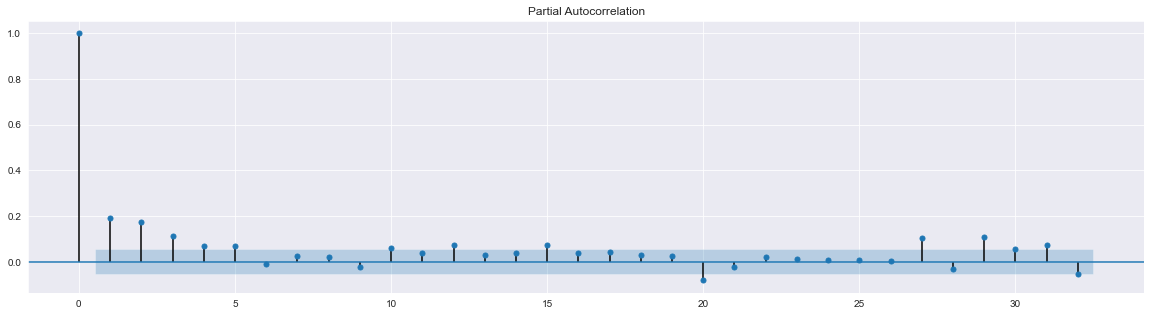

In [10]:
#acf = plot_acf(ret**2)
pacf = plot_pacf(ret**2)

## Fitting GARCH models

It seems (p,q) = (2, 2) is reasonable as a starting choice. Below we fit the GARCH model and examine the parameter summaries.

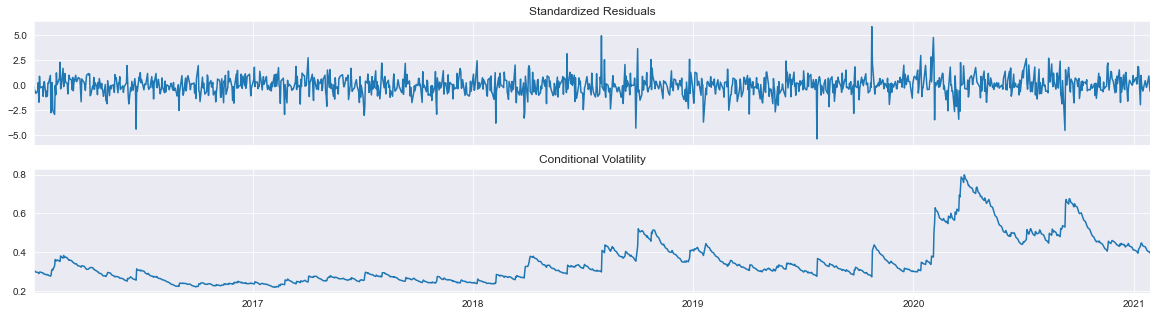

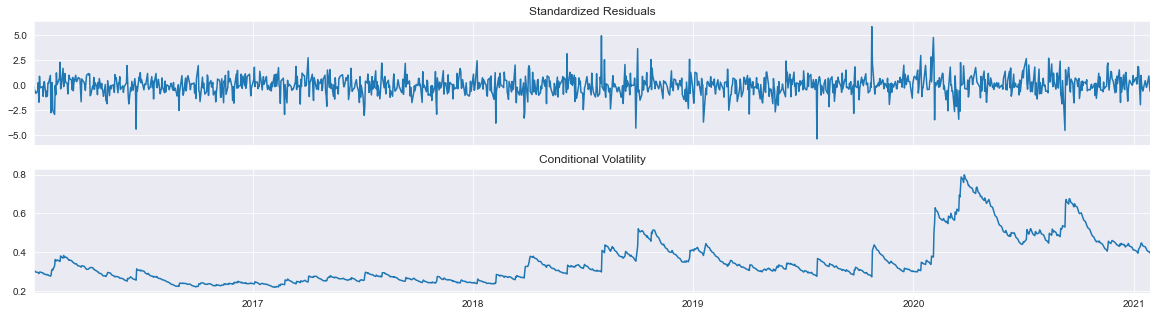

In [62]:
GARCH = arch_model(ret, p=1, o=1, q=1, dist = 't', rescale = True)
Gfit = GARCH.fit(disp = 'off')
Gfit.summary()

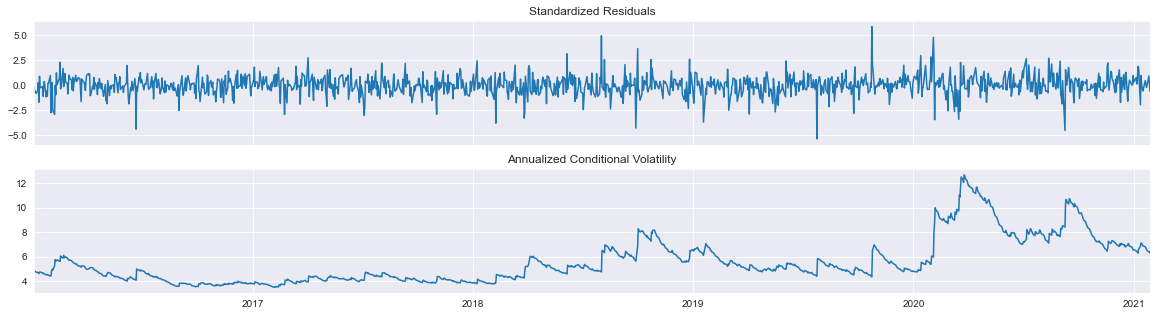

In [12]:
plt.rcParams["figure.figsize"] = (20, 5)
p = Gfit.plot(annualize='D')

The standardized residuals can be computed by dividing the residuals by the conditional volatility. These are plotted along with the (unstandardized, but scaled) residuals. The non-standardized residuals are more peaked in the center indicating that the distribution is somewhat more heavy tailed than that of the standardized residuals.

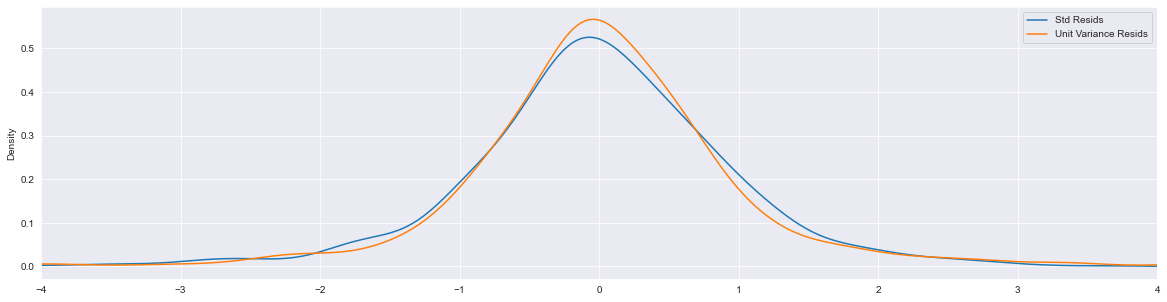

In [13]:
std_resid = Gfit.resid / Gfit.conditional_volatility
unit_var_resid = Gfit.resid / Gfit.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4, 4)

In [65]:
get_best_distribution(std_resid)

p value for norm = 3.782664675358186e-05
p value for skewnorm = 2.6932265965651855e-05
p value for t = 0.8415761593305383
p value for exponweib = 6.773814582793432e-05
p value for weibull_max = 1.1168675713003118e-10
p value for weibull_min = 2.2488462826953124e-11
p value for pareto = 1.1601513356811071e-256
p value for genextreme = 1.1136690292570552e-10
Best fitting distribution: t
Best p value: 0.8415761593305383
Parameters for the best fit: (3.7129503376265327, 0.008716950609011266, 0.6839703242403243)


('t',
 0.8415761593305383,
 (3.7129503376265327, 0.008716950609011266, 0.6839703242403243))

## Forecasting

Forecasts are contained in an `ARCHModelForecast` object which has 4 attributes:

* `mean` - The forecast means
* `residual_variance` - The forecast residual variances, that is $E_t[\epsilon_{t+h}^2]$
* `variance` - The forecast variance of the process, $E_t[r_{t+h}^2]$.  The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.
* `simulations` - An object that contains detailed information about the simulations used to generate forecasts.  Only used if the forecast `method` is set to `'simulation'` or `'bootstrap'`.  If using `'analytical'` (the default), this is `None`.

The three main outputs are all returned in `DataFrame`s with columns of the form `h.#` where `#` is the number of steps ahead.  That is, `h.1` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead.

The default forecast only produces 1-step ahead forecasts.

In [14]:
fc = Gfit.forecast()

print(fc.mean.iloc[-2:])
print(fc.residual_variance.iloc[-2:])
print(fc.variance.iloc[-2:])

                 h.1
Date                
2021-01-26       NaN
2021-01-27  0.017842
                 h.1
Date                
2021-01-26       NaN
2021-01-27  0.153672
                 h.1
Date                
2021-01-26       NaN
2021-01-27  0.153672


In [15]:
fc = Gfit.forecast(horizon=6)
print(fc.residual_variance.dropna().head())

                 h.1       h.2       h.3       h.4       h.5       h.6
Date                                                                  
2021-01-27  0.153672  0.153758  0.153844  0.153929  0.154014  0.154098


## Varying window forecasts

There are 3 main ways in which to construct forecasting windows:
    - fixed window forecasts, where we use all observations in the time series.
    - expanding window forecasts, where we incorporate new forecasts into our time series and make predictions based on the new expanded window
    - rolling window forecasts, where we include new forecasts at the end of our time series and drop equal number of values at the beginning
The `first_obs` and `last_obs` parameters are used as paramters into the `fit.forecast()` functions to achieve this.

In [46]:
Gfit = GARCH.fit(last_obs=dt.datetime.today(), disp= 'off')
fc = Gfit.forecast(horizon=6)
print(fc.variance.dropna().head())

                 h.1       h.2       h.3       h.4       h.5       h.6
Date                                                                  
2021-01-27  0.153672  0.153758  0.153844  0.153929  0.154014  0.154098


### Expanding

In [60]:
index = ret.index
start_loc = 0
end_loc = np.where(index >= '2019-12-29')[0].min()
#end_loc = len(ret)-21

forecasts = {}
window_size = 21
h = 6
for i in range(window_size):
    Gfit = GARCH.fit(last_obs = i + end_loc, disp='off')
    temp = Gfit.forecast(horizon=h).variance
    fc = temp.iloc[i + end_loc]
    forecasts[fc.name] = fc
expanding = pd.DataFrame(forecasts).T
print(expanding)


                 h.1       h.2       h.3       h.4       h.5       h.6
2019-12-30  0.063540  0.063923  0.064297  0.064664  0.065024  0.065376
2019-12-31  0.063181  0.063561  0.063935  0.064301  0.064660  0.065011
2020-01-02  0.062233  0.062632  0.063022  0.063406  0.063781  0.064149
2020-01-03  0.061897  0.062294  0.062683  0.063064  0.063439  0.063805
2020-01-06  0.061286  0.061686  0.062078  0.062463  0.062840  0.063210
2020-01-07  0.061237  0.061633  0.062020  0.062400  0.062773  0.063139
2020-01-08  0.062909  0.063263  0.063610  0.063950  0.064284  0.064611
2020-01-09  0.065392  0.065693  0.065988  0.066278  0.066563  0.066843
2020-01-10  0.064651  0.064959  0.065262  0.065559  0.065852  0.066139
2020-01-13  0.071487  0.071674  0.071857  0.072037  0.072214  0.072388
2020-01-14  0.074845  0.075015  0.075182  0.075347  0.075508  0.075667
2020-01-15  0.078771  0.078869  0.078967  0.079062  0.079156  0.079248
2020-01-16  0.079365  0.079456  0.079545  0.079633  0.079719  0.079805
2020-0

### Rolling

In [61]:
index = ret.index
start_loc = 0
end_loc = np.where(index >= '2019-12-29')[0].min()
#end_loc = len(ret)-21

forecasts = {}
window_size = 21
h = 6
for i in range(window_size):
    Gfit = GARCH.fit(first_obs = i + start_loc, last_obs = i + end_loc, disp='off')
    temp = Gfit.forecast(horizon=h).variance
    fc = temp.iloc[i + end_loc]
    forecasts[fc.name] = fc
rolling = pd.DataFrame(forecasts).T 
print(rolling)



                 h.1       h.2       h.3       h.4       h.5       h.6
2019-12-30  0.063540  0.063923  0.064297  0.064664  0.065024  0.065376
2019-12-31  0.063116  0.063470  0.063817  0.064157  0.064491  0.064819
2020-01-02  0.062303  0.062667  0.063024  0.063374  0.063718  0.064055
2020-01-03  0.062089  0.062439  0.062783  0.063121  0.063452  0.063777
2020-01-06  0.061676  0.062025  0.062368  0.062704  0.063034  0.063357
2020-01-07  0.061714  0.062051  0.062381  0.062705  0.063023  0.063335
2020-01-08  0.063525  0.063814  0.064097  0.064375  0.064649  0.064917
2020-01-09  0.066223  0.066475  0.066723  0.066967  0.067206  0.067442
2020-01-10  0.065614  0.065881  0.066143  0.066401  0.066654  0.066902
2020-01-13  0.072919  0.073048  0.073175  0.073300  0.073423  0.073543
2020-01-14  0.076386  0.076492  0.076597  0.076699  0.076800  0.076899
2020-01-15  0.080168  0.080213  0.080258  0.080302  0.080344  0.080387
2020-01-16  0.080473  0.080508  0.080541  0.080575  0.080607  0.080639
2020-0

In [59]:
#print(abs(rolling-expanding))

## Rolling window forecasts 2